# Rising up productivity of calculations using coordinate system transformation 

The article is to present easy way to speed up calculations including ray tracing stages. Such problems are very common in scientific researches based on modeling with gridded approach. Here I suggest to take a simplified forward seismic tomography problem.
What we need is to calculate set of traveltimes from known sources to known recievers throuh known velocity model.

Time from one source to one reciever is described by equation:
$$t = \sum_ {i}l_i c_i,$$
where $l_i$ is length of ray in $i$ th cell, and $c_i$ is slowness (opposite to velocity) in this cell.

To find out length of ray in model cell we have to trace it from start to finish and mark down all cells where ray appears. Here we make a simplification that the ray is straight line and all cells have rectange shape. 

Let's now go to coding not to lose logic line. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time

In [2]:
#use some class just for fun
class Source:
    def __init__(self, x_crd, y_crd):
        self.x = x_crd
        self.y = y_crd
class Reciever(Source):
    pass

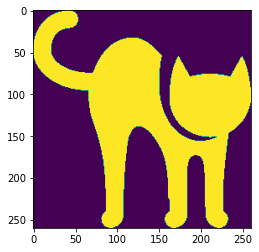

In [6]:
#import any image to use it as a 2D velocity model
response = requests.get('https://img1.freepng.ru/20180622/hgo/kisspng-whiskers-black-cat-domestic-short-haired-cat-sphyn-5b2d820011dcd9.4128472415297090560732.jpg')
model = np.array(Image.open(BytesIO(response.content)))[:,:,1]


model[model<=100] = 2
model[model>100] = 1

plt.imshow(model)

In [7]:
#here we set gridlines according to shape of model
x_lines = np.arange(np.shape(model)[1]+1)
y_lines = np.arange(np.shape(model)[0]+1)

dx = 1
dy = 1

ddy = 0.5

#setting list of sources and recievers by the left and right edges of model 
src_list = []
for i in range(0, len(y_lines)-1, 5):
    src_list.append(Source(x_lines[0], y_lines[i]+ddy))

rec_list = []
for i in range(0, len(y_lines)-1, 5):
    rec_list.append(Reciever(x_lines[-1], y_lines[i]+ddy))

As if we suppose ray is straight and cells are rectangels, we can find all crosses of ray and gridlines using linear equation like $y = ax+b$. The result we can use as an input for calculating length of ray parts in each cell.

In [8]:
#defining function to return points where ray crosses gridlines
def get_marker_points(start, fin, gridlines):

    x_lin, y_lin = gridlines[0], gridlines[1]

    k = (fin.y - start.y)/(fin.x-start.x)
    
    marker_points = []
    
    tmp_y = np.copy(start.y)
    tmp_x = np.copy(start.x)
    
    for cy in y_lin:
        dy = cy-tmp_y
        dx = dy/k
        tmp_x = tmp_x+dx
        marker_points.append((tmp_x, cy))
        tmp_y = cy
    
    tmp_y = np.copy(start.y)
    tmp_x = np.copy(start.x)
    for cx in x_lin:
        dx = cx-tmp_x
        dy = dx*k
        tmp_y = tmp_y+dy
        marker_points.append((cx, tmp_y))
        tmp_x = cx
        
    mpoints = sorted(marker_points, key=lambda x: x[0])
    
    clear_points = []
    clear_points.append(mpoints[0])
    for i in range(1,len(mpoints)):
        r = np.sqrt((mpoints[i][0]-mpoints[i-1][0])**2+(mpoints[i][1]-mpoints[i-1][1])**2)
        if r>1e-5:
            clear_points.append(mpoints[i])
    
    return clear_points

In [9]:
#defining function to calculate distance between points where ray crosses gridlines
def cell_length(pnts):
    c_len = []
    for i in range(len(pnts)-1):
        r = np.sqrt((pnts[i][0]-pnts[i+1][0])**2+(pnts[i][1]-pnts[i+1][1])**2)
        # if r>1e-5:
        c_len.append(r)
    return c_len

Now, lets think how can we find indexes of cell, which we need to use in first equation to get slowness of model in needed cell. The most trivial solution is to take middle points of ray parts (between crossings of grid lines) and find the cell, that suit conditions: $c_{l}<=x_{mid}<=c_{r}$ and $c_{lw}<=y_{mid}<=c_{up}$, which means that middle coordinate of ray part is inside (or on) the cell borders. Let's see how function returning indexes by that logic will be look like.  

In [10]:
def get_cell_ind(pnts, full_gridlines):
    
    xgrd, ygrd = full_gridlines[0], full_gridlines[1]
    
    mid_points = []
    for i in range(0,len(pnts)-1):
        hx = pnts[i][0]+(pnts[i+1][0]-pnts[i][0])/2
        hy = pnts[i][1]+(pnts[i+1][1]-pnts[i][1])/2
        
        mid_points.append((hx,hy))
        
    lx_ind = []
    ly_ind = []
    
    for mp in mid_points:
        for ix in range(len(xgrd)):
            if xgrd[ix]<mp[0]<xgrd[ix+1]:
                x_ind = ix
                break
        for iy in range(len(ygrd)):
            if ygrd[iy]<mp[1]<ygrd[iy+1]:
                y_ind = iy
                break
        ly_ind.append(y_ind)
        lx_ind.append(x_ind)
    
    cell_ind = (ly_ind, lx_ind)
    
    return cell_ind

The function looks very easy and logical, but not very productive - several input loops and a few 'if' conditions. What if we transform our substance and use some abstractions instead of operating physical values. Lets's change our coordinate system and use unit legth based on cell size instead of its physical shape. Then we got a situation, where cell index is encoded in ray part coordinates, after we transform them. So, we run out of need to use any 'if' conditions and loop. All we need is just to decode coordinates (mid points) of ray part to int format and use them as cell indexes.

In [11]:
def get_cell_ind_new(pnts, full_gridlines):
    
    dx = full_gridlines[0][1]-full_gridlines[0][0]
    dy = full_gridlines[1][1]-full_gridlines[1][0]
    
    x0 = full_gridlines[0][0]
    y0 = full_gridlines[1][0]
    
    cell_pnts = np.array(pnts)
    cell_pnts[:,0] = (cell_pnts[:,0]-x0)/dx
    cell_pnts[:,1] = (cell_pnts[:,1]-y0)/dy
    
    mid_points = np.zeros((len(pnts)-1,2))
    for i in range(0,len(pnts)-1):
        hx = cell_pnts[i,0]+(cell_pnts[i+1,0]-cell_pnts[i,0])/2
        hy = cell_pnts[i,1]+(cell_pnts[i+1,1]-cell_pnts[i,1])/2
        
        mid_points[i,1] = hx        
        mid_points[i,0] = hy

    inds = (np.array(mid_points[:,0], dtype = int) ,np.array(mid_points[:,1], dtype = int))
    
    return inds

Lets's define a function that count traveltime and compare both approaches.

In [34]:
def count_time(v_model, r_length, ind_list):
    
    slow_model = 1/v_model[ind_list]
    
    time = np.sum(slow_model*r_length)
    
    return time

In [35]:
#Here we set two lists for counted traveltime for both cases, just to check we have same calculation result
t_vector_1 = [] #for loop and if function
t_vector_2 = [] #for swap system coordinate function

In [36]:
#counting traveltime and estimating required time
time_start = time.time()

full_gridlines = (x_lines, y_lines)
for i, src in enumerate(src_list):
    print(str(i)+'/'+str(len(src_list)))
    for j, rec in enumerate(rec_list):
                
        ymin = np.min([src.y, rec.y])
        ymax = np.max([src.y, rec.y])
        
        xmin = np.min([src.x, rec.x])
        xmax = np.max([src.x, rec.x])
        
        y_lin = y_lines[(y_lines<=ymax) & (y_lines>=ymin)]
        x_lin = x_lines[(x_lines<=xmax) & (x_lines>=xmin)]
        
        points = get_marker_points(src, rec, (x_lin, y_lin))
        vec_len = cell_length(points)
        
        #ind_list = get_cell_ind_new(points, full_gridlines)
        ind_list = get_cell_ind(points, full_gridlines)
        
        c_times = count_time(model, vec_len, ind_list)
        t_vector_1.append(c_times)
        

time_exp = time.time() - time_start  

0/52
1/52
2/52
3/52
4/52
5/52
6/52
7/52
8/52
9/52
10/52
11/52
12/52
13/52
14/52
15/52
16/52
17/52
18/52
19/52
20/52
21/52
22/52
23/52
24/52
25/52
26/52
27/52
28/52
29/52
30/52
31/52
32/52
33/52
34/52
35/52
36/52
37/52
38/52
39/52
40/52
41/52
42/52
43/52
44/52
45/52
46/52
47/52
48/52
49/52
50/52
51/52


In [37]:
time_exp

458.7626633644104

On a laptop with Intel i7 time for first approach is 458 sec, which is quiete expensive. Let's see results with a second one.

In [38]:
time_start = time.time()

full_gridlines = (x_lines, y_lines)
for i, src in enumerate(src_list):
    print(str(i)+'/'+str(len(src_list)))
    for j, rec in enumerate(rec_list):
                
        ymin = np.min([src.y, rec.y])
        ymax = np.max([src.y, rec.y])
        
        xmin = np.min([src.x, rec.x])
        xmax = np.max([src.x, rec.x])
        
        y_lin = y_lines[(y_lines<=ymax) & (y_lines>=ymin)]
        x_lin = x_lines[(x_lines<=xmax) & (x_lines>=xmin)]
        
        points = get_marker_points(src, rec, (x_lin, y_lin))
        vec_len = cell_length(points)
        
        ind_list = get_cell_ind_new(points, full_gridlines)
        #ind_list = get_cell_ind(points, full_gridlines)
        
        c_times = count_time(model, vec_len, ind_list)
        t_vector_2.append(c_times)
        

time_exp = time.time() - time_start  

0/52
1/52
2/52
3/52
4/52
5/52
6/52
7/52
8/52
9/52
10/52
11/52
12/52
13/52
14/52
15/52
16/52
17/52
18/52
19/52
20/52
21/52
22/52
23/52
24/52
25/52
26/52
27/52
28/52
29/52
30/52
31/52
32/52
33/52
34/52
35/52
36/52
37/52
38/52
39/52
40/52
41/52
42/52
43/52
44/52
45/52
46/52
47/52
48/52
49/52
50/52
51/52


In [39]:
time_exp

13.51807165145874

The second approach took only 13 seconds to the same calculation! It is 35 times faster. what we have to do is to check, that all calculations give the same result.

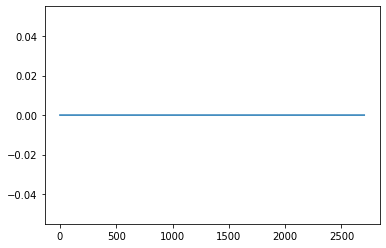

In [42]:
diff = np.array(t_vector_2)-np.array(t_vector_1)
er = np.sum(diff)
plt.plot(diff)

Here we can see that results are the same.

In this notebook we showed that problems dealing with medium properties depending on coordinate, such as seismic 
tomography, could be speed up to several times by simple abstraction, such as transformation of coordinate system. 
The rising of productivity is the more significant the more complicated calculations are.   

Traveltime for a cat model as a bonus.

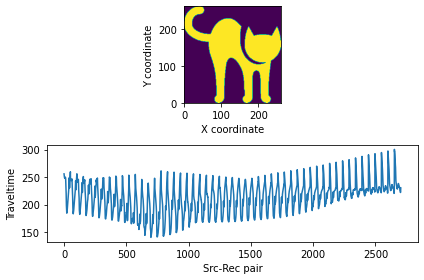

In [50]:
fig, ax = plt.subplots(2,1)
ext = [0,np.shape(model)[1], 0,np.shape(model)[0]]
ax[0].imshow(model, extent = ext)
ax[0].set_xlabel('X coordinate')
ax[0].set_ylabel('Y coordinate')

ax[1].plot(t_vector_1)
ax[1].set_xlabel('Src-Rec pair')
ax[1].set_ylabel('Traveltime')

fig.tight_layout() 